In [1]:
import numpy as np
from typing import SupportsIndex
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [2]:
class KNN:
    """
    Class implementing the k-nearest neighbors algorithm.
    """

    def __init__(self, n_neighbors: int = 4):
        self.X_train = None
        self.y_train = None
        self.n_neighbors = n_neighbors

    def fit(self, X: np.ndarray, y: SupportsIndex):
        """
        Fits the KNN model to the training data. 
        In KNN, "fitting" simply involves storing the training dataset.        
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts labels for a set of input samples.
        """
        # Compute the Euclidean distance between each sample in X and each sample in self.X_train
        distances = np.linalg.norm(X[:, np.newaxis] - self.X_train, axis=2)

        # Get the indices of the n_neighbors closest samples
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        # Aggregate the labels of the nearest neighbors
        nearest_labels = self.y_train[nearest_indices]

        # Return the most common class label among the nearest neighbors
        from scipy.stats import mode
        return mode(nearest_labels, axis=1)[0].flatten()     

In [3]:
def accuracy(labels_true: np.ndarray, labels_pred: np.ndarray) -> float:
    """
    Computes the fraction of correctly predicted labels.
    """
    return np.sum(labels_true == labels_pred) / len(labels_true)

In [4]:
def metric(labels_true: np.ndarray, labels_pred: np.ndarray) -> float:
    """
    Implements an additional classification metric: F1 score.
    """
    tp = np.sum((labels_true == 1) & (labels_pred == 1))
    fp = np.sum((labels_true == 0) & (labels_pred == 1))
    fn = np.sum((labels_true == 1) & (labels_pred == 0))
    
    if tp + fp == 0 or tp + fn == 0:
        return 0.0  
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1

Dataset shape: (290, 2) (290,)
Train/test shapes: (203, 2) (87, 2)
n_neighbors=1
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87        57
         1.0       0.74      0.83      0.78        30

    accuracy                           0.84        87
   macro avg       0.82      0.84      0.83        87
weighted avg       0.85      0.84      0.84        87

Accuracy: 0.8391 [ours]
F1 score: 0.7812 [custom]
_______________________________________________________
n_neighbors=2
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89        57
         1.0       0.81      0.73      0.77        30

    accuracy                           0.85        87
   macro avg       0.84      0.82      0.83        87
weighted avg       0.85      0.85      0.85        87

Accuracy: 0.8506 [ours]
F1 score: 0.7719 [custom]
_______________________________________________________
n_neighbors=3
              precision  

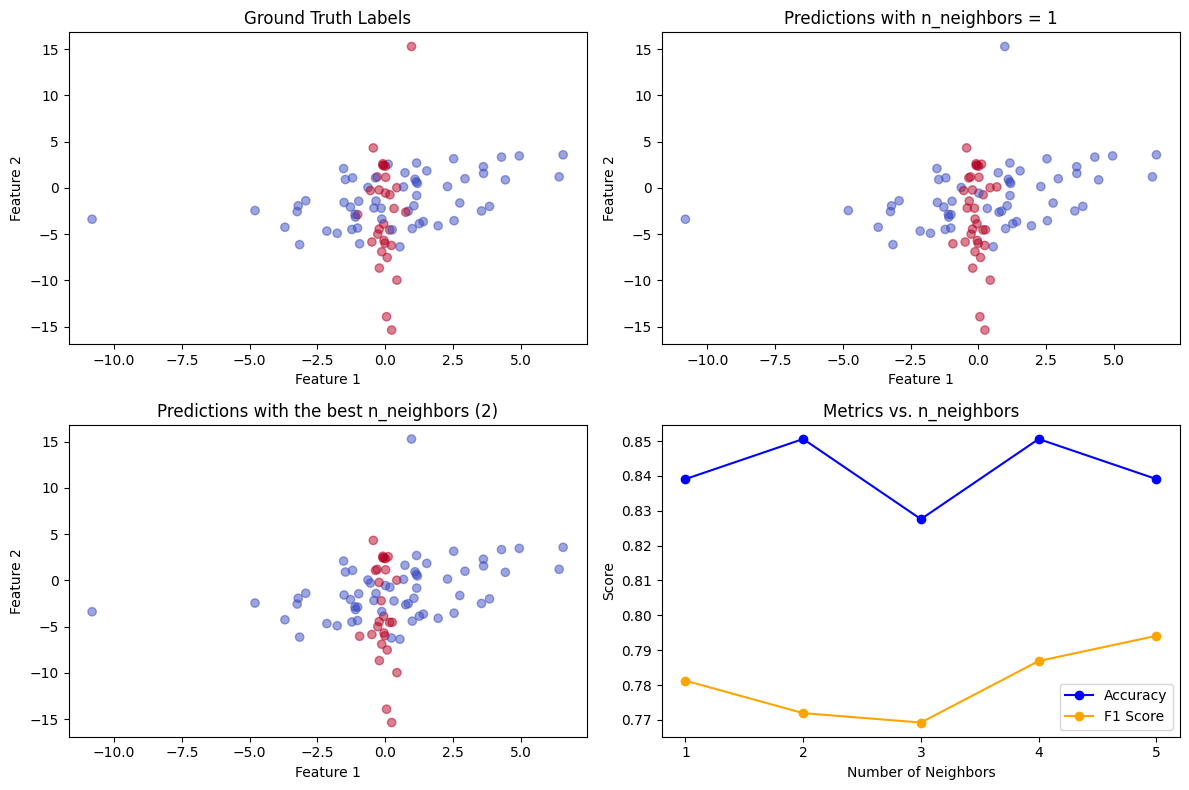

In [5]:
if __name__ == "__main__":
    # Fix random seed for reproducibility
    np.random.seed(100)

    # Create synthetic dataset for training and testing
    means0, covs0 = [1, -1], [[7, 3], [3, 7]]
    x0, y0 = np.random.multivariate_normal(means0, covs0, 190).T

    means1, covs1 = [0, -4], [[0.1, 0.0], [0.0, 25]]
    x1, y1 = np.random.multivariate_normal(means1, covs1, 100).T

    # Convert data to the appropriate format
    data0, labels0 = np.vstack([x0, y0]).T, np.zeros(len(x0))
    data1, labels1 = np.vstack([x1, y1]).T, np.ones(len(x1))

    data = np.vstack([data0, data1])
    labels = np.hstack([labels0, labels1])
    total_size = data.shape[0]
    print("Dataset shape:", data.shape, labels.shape)

    # Split dataset into 70% train and 30% test
    train_size = int(total_size * 0.7)
    indices = np.random.permutation(total_size)
    X_train, y_train = data[indices][:train_size], labels[indices][:train_size]
    X_test, y_test = data[indices][train_size:], labels[indices][train_size:]
    print("Train/test shapes:", X_train.shape, X_test.shape)

    # Loop through different values of n_neighbors (1 to 5)
    neighbors_range = range(1, 6)
    accuracies = []
    f1_scores = []

    for n_neighbors in neighbors_range:
        predictor = KNN(n_neighbors=n_neighbors)
        predictor.fit(X_train, y_train)
        y_pred = predictor.predict(X_test)

        acc = accuracy(y_test, y_pred)
        f1 = metric(y_test, y_pred)
        accuracies.append(acc)
        f1_scores.append(f1)
        
        print(f"n_neighbors={n_neighbors}")
        print(classification_report(y_test, y_pred))
        
        print("Accuracy: %.4f [ours]" % accuracy(y_test, y_pred))
        assert abs(accuracy_score(y_test, y_pred) - accuracy(y_test, y_pred)) < 1e-5, \
            "Implemented accuracy is not the same as sci-kit learn one!"
        
        # Check classifier performance
        assert accuracy_score(y_test, y_pred) > 190. / 290, "Your classifier is worse than the constant!"
        
        # Calculate additional metric and compare with library version
        print("F1 score: %.4f [custom]" % metric(y_test, y_pred))

        assert abs(metric(y_test, y_pred) - f1_score(y_test, y_pred)) < 1e-5, \
            "Custom metric does not match sklearn metric!"

        print('_'*55)


    
    # Visualize the results
    plt.figure(figsize=(12, 8))

    # Ground truth labels
    plt.subplot(221)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', alpha=0.5)
    plt.title('Ground Truth Labels')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Predictions with n_neighbors = 1
    predictor = KNN(n_neighbors=1)
    predictor.fit(X_train, y_train)
    y_pred_1 = predictor.predict(X_test)
    plt.subplot(222)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_1, cmap='coolwarm', alpha=0.5)
    plt.title('Predictions with n_neighbors = 1')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Predictions with the best n_neighbors
    best_n_neighbors = neighbors_range[np.argmax(accuracies)]
    predictor = KNN(n_neighbors=best_n_neighbors)
    predictor.fit(X_train, y_train)
    y_pred_best = predictor.predict(X_test)
    plt.subplot(223)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_best, cmap='coolwarm', alpha=0.5)
    plt.title(f'Predictions with the best n_neighbors ({best_n_neighbors})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Plot metrics as functions of n_neighbors
    plt.subplot(224)
    plt.plot(neighbors_range, accuracies, label='Accuracy', color='blue', marker='o')
    plt.plot(neighbors_range, f1_scores, label='F1 Score', color='orange', marker='o')
    plt.title('Metrics vs. n_neighbors')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.xticks(neighbors_range)
    plt.legend()

    plt.tight_layout()
    plt.savefig('knn_results.png')
    plt.show()